In [1]:
!pip install wandb

^C
ERROR: Operation cancelled by user


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import re
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torchvision
import seaborn as sns
import albumentations as A
import cv2
import torch.functional as F
import gc
from collections import namedtuple

from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import sigmoid_focal_loss
from torch.nn import BCEWithLogitsLoss
from PIL import Image
from matplotlib.image import imread
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import roc_auc_score
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.loggers import WandbLogger

In [3]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

seed_everything(SEED)

In [4]:
def plot_samples(imgs: pd.DataFrame, n_samples=15, n_cols=5):
    n_rows = n_samples // n_cols
    samples = imgs.sample(n_samples)
    f, axes = plt.subplots(n_rows, n_cols, figsize=(15,10))
    for i, ax in enumerate(axes.flatten()):
        img = imread(samples.img_path.iloc[i])
        ax.imshow(img)
        ax.set_title(samples.title.iloc[i])
    plt.show()

In [5]:
TRAIN_DF_IMAGES_PATH = '/kaggle/input/aaacontacts/train_images.csv'
TRAIN_DF_ITEMS_PATH = '/kaggle/input/aaacontacts/train_items.csv'
SAMPLE_SUBMISSION_PATH = '/kaggle/input/aaacontacts/sample_submission.csv'

TRAIN_IMAGES_PATH = '/kaggle/input/aaacontacts/images_for_train/images_for_train'
TEST_IMAGES_PATH = '/kaggle/input/aaacontacts/images_for_test/images_for_test'
SYNTHETIC = '/kaggle/input/synthetic-contacts/kaggle/working/synthetic'

FP = [53172,
 601147,
 292873,
 493449,
 589298,
 888510,
 269015,
 801339,
 736448,
 784651,
 943937,
 25915,
 943359,
 694316,
 787444,
 274419,
 438667,
 873392,
 71520,
 755546,
 878753]
TP = []
ERRORS = FP + TP

In [6]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101101 entries, 0 to 101100
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   image       101101 non-null  int64  
 1   prediction  101101 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


In [8]:
imgs_df = pd.read_csv('/kaggle/input/aaacontacts-toloka-labeling/labeled_6000.csv')
items_df = pd.read_csv('/kaggle/input/aaacontacts/train_items.csv')
imgs_df['img_path'] = imgs_df.image.apply(lambda x: os.path.join(TRAIN_IMAGES_PATH, str(x) + '.jpg'))

In [9]:
imgs_df.head()

,item,image,is_first_photo,is_contact,img_path
0,924899,290210,0,NaN,/kaggle/input/aaacontacts/images_for_train/ima...
1,141462,966513,1,0.0,/kaggle/input/aaacontacts/images_for_train/ima...
2,975486,470939,0,NaN,/kaggle/input/aaacontacts/images_for_train/ima...
3,413752,659124,0,NaN,/kaggle/input/aaacontacts/images_for_train/ima...
4,322417,281120,1,NaN,/kaggle/input/aaacontacts/images_for_train/ima...


In [10]:
(~imgs_df.is_contact.isna()).sum()

6149

In [11]:
items_df.head()

,item,is_blocked,description,title,category
0,501243,1,"Услуги погрузчика ПКУ-0,8 КУН, очистка террито...","Услуги погрузчика пку-0,8(кун)",Услуги
1,288183,1,Красный пропуск .Эвакуация/перевозка грузовых...,Эвакуатор грузовиков краснодар красный пропуск,Услуги
2,287025,1,Учитель русского языка первой! квалификационн...,"Репетитор по русскому языку, учитель",Услуги
3,311113,1,Продаются саженцы АКТИНИДИИ девочки Кенс Ред....,"Виноград, актинидии, кизил, орех фундук",Для дома и дачи
4,956880,1,"Шикарный вариант под офис, салон красоты, апте...","Помещение свободного назначения, 100 м²",Недвижимость


In [12]:
imgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100368 entries, 0 to 100367
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item            100368 non-null  int64  
 1   image           100368 non-null  int64  
 2   is_first_photo  100368 non-null  int64  
 3   is_contact      6149 non-null    float64
 4   img_path        100368 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ MB


In [13]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11386 entries, 0 to 11385
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item         11386 non-null  int64 
 1   is_blocked   11386 non-null  int64 
 2   description  11339 non-null  object
 3   title        11386 non-null  object
 4   category     11386 non-null  object
dtypes: int64(2), object(3)
memory usage: 444.9+ KB


In [14]:
df = imgs_df.merge(items_df, how='left', left_on='item', right_on='item')

In [15]:
(~df.is_contact.isna()).sum()

6149

In [16]:
df.is_blocked.value_counts()

1    50651
0    49717
Name: is_blocked, dtype: int64

In [17]:
df.loc[:, 'is_contact'] = df.is_contact.astype('Int32')  # pandas bug

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100368 entries, 0 to 100367
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   item            100368 non-null  int64 
 1   image           100368 non-null  int64 
 2   is_first_photo  100368 non-null  int64 
 3   is_contact      6149 non-null    Int32 
 4   img_path        100368 non-null  object
 5   is_blocked      100368 non-null  int64 
 6   description     100311 non-null  object
 7   title           100368 non-null  object
 8   category        100368 non-null  object
dtypes: Int32(1), int64(4), object(4)
memory usage: 7.4+ MB


In [19]:
df.description.fillna('', inplace=True)

In [20]:
df = df[~df.is_contact.isna()]
df.loc[df.image.isin(ERRORS), 'is_contact'] = 1 - df.loc[df.image.isin(ERRORS), 'is_contact']  # clean errors
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6149 entries, 1 to 100363
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   item            6149 non-null   int64 
 1   image           6149 non-null   int64 
 2   is_first_photo  6149 non-null   int64 
 3   is_contact      6149 non-null   Int32 
 4   img_path        6149 non-null   object
 5   is_blocked      6149 non-null   int64 
 6   description     6149 non-null   object
 7   title           6149 non-null   object
 8   category        6149 non-null   object
dtypes: Int32(1), int64(4), object(4)
memory usage: 462.4+ KB


In [21]:
df.loc[df.image.isin(ERRORS), 'is_contact']

150      0
3680     0
3813     0
4735     0
4860     0
5670     0
6944     0
13824    0
20390    0
29894    0
30195    0
35562    0
38487    0
39870    0
41608    0
43532    0
48397    0
48541    0
75376    0
75508    0
98873    0
Name: is_contact, dtype: Int32

## Ищу закономерности в текстовых описаниях

In [22]:
df[(df.category == 'Услуги') & (df.is_blocked == 1) & (df.is_contact == 1)][['description', 'img_path']].description.iloc[3
                                                                                                                         ]

'Поездки на море быстро с комфортом\nРаботаем Ставрополь Изобильненский, Красногвардейский, Ипатовский, Апанасенковские районы\n\n❌❌❌❌❌❌❌❌❌❌❌❌❌\nТуры в Домбай, Архыз, Кисловодск, Краснодар, Гуамское ущелье, Лаго-Наки, Эльбрус.\n❌❌❌❌❌❌❌❌❌❌❌❌❌\n\n🚐Осуществляем Междугородние перевозки на   комфортабельном микроавтобусе 7 пассажирских мест, забираем с аэропортов и ЖД вокзалов, с роддома, деловые встречи,свадьбы, море, горы, доставим быстро и комфортно.\n🚐По предварительному заказу осуществляем поездки в Домбай, Архыз, Эльбрус, Лаго-Наки, Кисловодск, Гуамское ущелье, Краснодар, Сочи, Крым, Чечня, Дагестан, КБР, Осетия, также по всей территории РФ. 🌍\nОтвезем вас по вашему желанию куда захотите, цены договорные и приемлемые. Водители имеют профессииональный стаж более 20 лет. \nЗвоните пишите будем рады вам помочь. \n\n☎️WhatsApp\nНаша страничка в инстаграме\npoehali_s_nami'

In [23]:
df.loc[:, 'whatsapp'] = df.description.apply(lambda x: any(text in x.lower() for text in \
                                                           ['whatsapp', 'вотсапп', '@', 'tg', 'telegram', 'vk', 'телеграм', 'телега', 'вк','вконтакте', 'vk']                                                          )).astype(int)
df[['whatsapp', 'is_contact']].corr()

,whatsapp,is_contact
whatsapp,1.000000,0.025629
is_contact,0.025629,1.000000


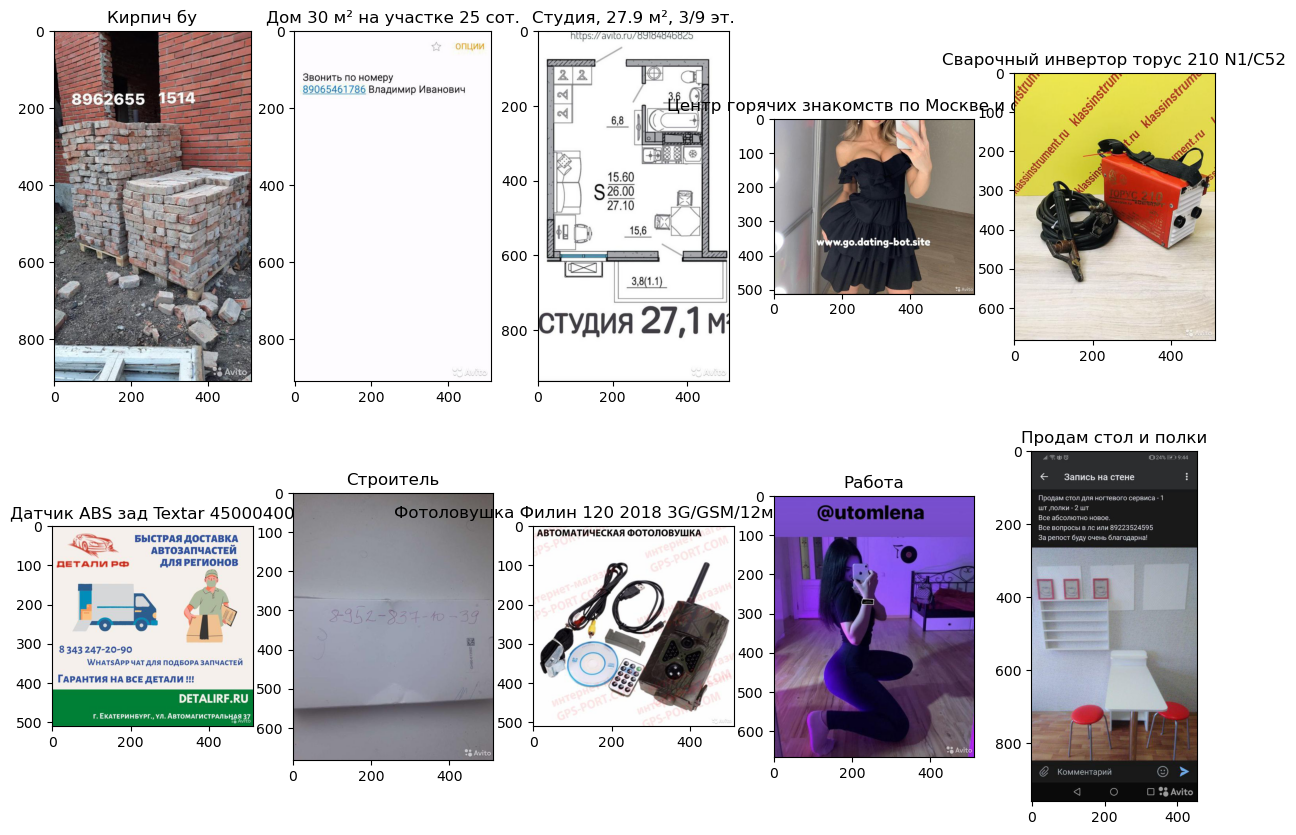

In [24]:
plot_samples(
    df[
        (df.description.apply(lambda x: 'на фото' in x)) & \
        (df.is_contact == 1)
    ], 10
)

## preparing

In [25]:
MODELS = dict()  # словарь для всех моделей

In [26]:
rng=np.random.RandomState(SEED)

def get_ci_auc( y_true, y_pred ): 

#     from scipy.stats import sem
   
    n_bootstraps = 1000   
    bootstrapped_scores = []   
   
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
       
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)   
 
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

   # 90% c.i.
   # confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
   # confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
 
   # 95% c.i.
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
   
    return confidence_lower, confidence_upper

In [27]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.DataFrame, mode='train', transforms=None):
        super().__init__()
        self.imgs = data.img_path.values
        self.labels = data.is_contact.values if mode in ['train', 'val'] else None
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.labels is not None:
            label = self.labels[idx]
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        if self.mode in ['train', 'val']:
            return img, label, img_path
        return img, img_path
        

In [28]:
X_train, X_val = train_test_split(df, train_size=0.7, random_state=42, stratify=df.is_contact)

In [29]:
X_train.shape, X_val.shape

((4304, 10), (1845, 10))

In [30]:
X_train.head()

,item,image,is_first_photo,is_contact,img_path,is_blocked,description,title,category,whatsapp
5265,331901,885069,1,0,/kaggle/input/aaacontacts/images_for_train/ima...,0,"К продаже предлагается прекрасная ""распашонка""...","2-к квартира, 61.2 м², 20/20 эт.",Недвижимость,0
37799,565657,629364,1,0,/kaggle/input/aaacontacts/images_for_train/ima...,0,Сдам однокомнатную квартиру ост. Кравченко. Ес...,"1-к. квартира, 42 м², 3/10 эт.",Недвижимость,1
50862,352414,681285,1,0,/kaggle/input/aaacontacts/images_for_train/ima...,1,"Группа Компании ""РентекАгро"" предлагает фермер...",Реконструкция семейных ферм крс Ремонт коровников,Услуги,1
212,783093,363252,1,0,/kaggle/input/aaacontacts/images_for_train/ima...,0,Сдаю 1-но комнатную квартиру напротив Школы Ми...,"1-к квартира, 40 м², 6/10 эт.",Недвижимость,0
9063,699801,211886,1,0,/kaggle/input/aaacontacts/images_for_train/ima...,0,Крышка багажника Cубару Импреза GG 00-07 60800...,Крышка багажника Cубару Импреза GG 00-07 60800...,Транспорт,0


In [31]:
SIZE = 224

train_transforms = A.Compose([
    A.Resize(SIZE, SIZE),

    A.OneOf([
        A.RandomBrightnessContrast(always_apply=False, p=0.3, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
        A.GridDistortion(always_apply=False, p=0.3, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, normalized=False),
        A.MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 7), allow_shifted=True),
        A.PiecewiseAffine(always_apply=False, p=0.5, scale=(0.03, 0.05), nb_rows=(4, 4), nb_cols=(4, 4), interpolation=0, mask_interpolation=0, cval=0, cval_mask=0, mode='constant', absolute_scale=0, keypoints_threshold=0.01)
    ], p=0.3),
    
    A.OneOf([
        A.SafeRotate(
            always_apply=False, p=0.3, limit=(-90, 90), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None
        ),
        A.Perspective(
            always_apply=False, p=0.3, scale=(0.05, 0.1), keep_size=1, pad_mode=0, pad_val=(0, 0, 0), mask_pad_val=0, fit_output=0, interpolation=0
        ),
    ], p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(SIZE, SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
test = pd.DataFrame({'img_path': sample_submission.image.apply(
    lambda x: os.path.join(TEST_IMAGES_PATH, str(x) + '.jpg')
).values})

train_dataset = Dataset(X_train, mode='train', transforms=train_transforms)
val_dataset = Dataset(X_val, mode='val', transforms=test_transforms)
test_dataset = Dataset(test, mode='test', transforms=test_transforms)

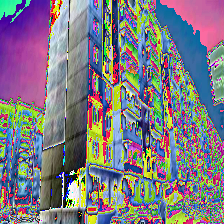

In [32]:
torchvision.transforms.ToPILImage()(train_dataset[1][0])

In [33]:
class Resnet18(pl.LightningModule):
    def __init__(
        self, 
        lr, 
        focal_cfg: dict = None, 
        pos_weight: torch.Tensor = None, 
        smooth=None, 
        schedule=None
):
        """layers"""
        super().__init__()
        self.save_hyperparameters()
        
        # init a pretrained resnet
        backbone = torchvision.models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights.DEFAULT)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-3]
        self.feature_extractor = nn.Sequential(*layers)
        
        unfreezed_layers = list(backbone.children())[-3:-1]
        self.unfreezed = nn.Sequential(*unfreezed_layers)
        self._set_requires_grad(self.unfreezed, requires_grad=True)

        # use the pretrained model to classify cifar-10 (10 image classes)
        num_target_classes = 1
        self.classifier = nn.Linear(num_filters, num_target_classes)
        
        self.lr = lr
        self.smooth = smooth
        self.focal_cfg = focal_cfg
        self.loss = BCEWithLogitsLoss(pos_weight=pos_weight)
        self.schedule = schedule
        
    @staticmethod
    def _set_requires_grad(model, requires_grad):
        for param in model.parameters():
            param.requires_grad = requires_grad
        
    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x)
        x = self.classifier(self.unfreezed(representations).flatten(1))
        return x  

    def _calc_loss(self, logits, y):
        if self.focal_cfg is not None:
            return sigmoid_focal_loss(logits, y.float(), **self.focal_cfg).mean()
        return self.loss(logits, y.float())
        
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        imgs, y, path = batch
        logits = self(imgs).squeeze(1)
        non_smoothed = y.detach().clone().float()
        if self.smooth is not None:
            smth = torch.from_numpy(np.random.uniform(0.0, self.smooth, y.shape[0])).to(self.device)
            y = (1 - smth) * y + smth / 2
        loss = self._calc_loss(logits, y)    
        batch_size = imgs.shape[0]
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return {
            'loss': loss,
            'logits': logits,
            'y_true': non_smoothed
        }

    def training_epoch_end(self, outs):
        all_preds = torch.cat([x['logits'] for x in outs]).detach().cpu().numpy()
        all_y_true = torch.cat([x['y_true'] for x in outs]).detach().cpu().numpy()
        auroc = roc_auc_score(all_y_true, all_preds)
        self.log('train_auc', auroc, logger=True, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        # this is the test loop
        imgs, path = batch
        logits = self(imgs).squeeze(1)
        loss = self.loss(logits, y.float())
        batch_size = imgs.shape[0]
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batcg_size=batch_size)
        retur
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        imgs, y, path = batch
        logits = self(imgs).squeeze(1)
        loss = self._calc_loss(logits, y)
        batch_size = imgs.shape[0]
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        
        return {
            'logits': logits, 
            'y_true': y
        }
    
    def validation_epoch_end(self, outs):
        all_preds = torch.cat([x['logits'] for x in outs]).detach().cpu().numpy()
        all_y_true = torch.cat([x['y_true'] for x in outs]).detach().cpu().numpy()
        auroc = roc_auc_score(all_y_true, all_preds)
        lower, higher = get_ci_auc(all_y_true, all_preds)
        self.log('val_auc', auroc, logger=True, prog_bar=True)
        self.log('lower', lower, logger=True, prog_bar=False)
        self.log('higher', higher, logger=True, prog_bar=False)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        if self.schedule:
            sch = torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                self.schedule
            )
            return [optimizer], [sch]
        return optimizer
    

In [34]:
pos = X_train.is_contact.sum()
neg = X_train.shape[0] - pos
POS_WEIGHT = torch.tensor([neg / pos], device='cuda')  # class-balancing weight

In [36]:
BATCH_SIZE = 32
LR=1e-3
BREAKING_STEP1 = 40
BREAKING_STEP2 = 70
SMOOTH = None
MIN_DELTA = 0.0
PATIENCE = 3
MAX_EPOCHS = 15
# FOCAL_CFG = {
#     'alpha': pos / (neg + pos), 
#     'gamma': 0.75
# }
FOCAL_CFG = None
# LOSS = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# EXP_NAME = 'labeled_6093_resnet18'
RUN_NAME = 'final'

def schedule(step_number, breaking_step1=BREAKING_STEP1, breaking_step2=BREAKING_STEP2):
    if step_number < breaking_step1:
        return step_number / breaking_step1
    elif step_number < breaking_step2:
        return 1
    else:
        return (0.99 ** (step_number - breaking_step2))
    
model = Resnet18(
    lr=LR, 
    focal_cfg=FOCAL_CFG,
    pos_weight=POS_WEIGHT,
    smooth=SMOOTH, 
    schedule=schedule,
#     loss_fn=LOSS
)

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

early_stop_callback = EarlyStopping(
    monitor="val_auc", 
    min_delta=MIN_DELTA, 
    patience=PATIENCE, 
    verbose=False, 
    mode="max", 
)

wandb_logger = WandbLogger(
    name=RUN_NAME,
    save_dir='/kaggle/working',
    project="avito_contacts",
    log_model=True
)
wandb_logger.experiment.config['batch_size'] = BATCH_SIZE

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=2,
    monitor="val_auc",
    mode="max",
    dirpath="/kaggle/working/",
    filename=RUN_NAME + "-{epoch:02d}-{val_auc:.4f}",
)

trainer = pl.Trainer(
    accelerator='gpu', 
    devices=1, 
    callbacks=[checkpoint_callback, early_stop_callback], 
    max_epochs=10,
    logger=wandb_logger,
    profiler='simple',
#     overfit_batches=1,
#     default_root_dir="/kaggle/working"
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [37]:
trainer.fit(
    model, 
    train_dataloaders=train_dl, 
    val_dataloaders=val_dl, 
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /kaggle/working exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [38]:
MODELS[RUN_NAME] = trainer.checkpoint_callback.best_model_path
MODELS[RUN_NAME]

'/kaggle/working/final-epoch=03-val_auc=0.7889.ckpt'

### Функции для инференсов

In [39]:
def score(
    model,
    path,
    val_dataloader,
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.load_from_checkpoint(path).to(device)
    
    y_hat = []
    losses = []
    y_true = []
    loss_fn = BCEWithLogitsLoss(pos_weight=POS_WEIGHT, reduction='none')
    model.eval()
    with torch.no_grad():
        for i, (imgs, labels, _) in enumerate(tqdm(val_dataloader)):
            imgs = imgs.to(device)
            logits = model(imgs)
            loss = loss_fn(labels.float().to(device), logits.flatten()).tolist()
            
            losses.extend(loss)
            y_hat.extend(logits.cpu().tolist())
            y_true.extend(labels.tolist())
            
    del imgs, logits, loss
    gc.collect()
    torch.cuda.empty_cache()
    
    auc = roc_auc_score(y_true, y_hat)
    lower, higher = get_ci_auc(np.array(y_true), np.array(y_hat))
    return auc, lower, higher, y_true, y_hat, losses


def predict(
    model,
    path,
    test_dataloader,
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.load_from_checkpoint(path).to(device)
    
    y_hat = []    
    model.eval()
    with torch.no_grad():
        for i, (imgs, _) in enumerate(tqdm(test_dataloader)):
            imgs = imgs.to(device)
            probs = torch.sigmoid(model(imgs))
            y_hat.extend(probs.cpu().tolist())
            
    del imgs, probs
    gc.collect()
    torch.cuda.empty_cache()
    return y_hat


### активное обучение

In [44]:
def enthropy(
    x: np.array
) -> np.array:
    return (-x * np.log(x) - (1 - x) * np.log(1 - x))

In [45]:
def active_learning(
    probs: np.array,
    pathes: np.array,
    active_learning_samples=100,
    n_samples=15,
    n_cols=5
):
    inds = np.argsort(cross_entropy(probs))[::-1]
    uncertain_probs = probs[inds]
    uncertain_pathes = pathes[inds]
    n_rows = n_samples // n_cols
    f, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        img = imread(uncertain_pathes[i])
        ax.imshow(img)
        title = f"{uncertain_pathes[i].split('/')[-1]}\n{round(uncertain_probs[i], 4)}"
        ax.set_title(title)
    plt.show()
    return uncertain_pathes[:active_learning_samples]

### Функция для вывода картинок, на которых модель сильно ошибается (поиск мисслейблов)

In [46]:
def plot_preds(
    logits: np.array,
    labels: np.array,
    pathes: np.array,
    figsize: tuple=(15, 10),
    n_samples=15,
    n_cols=5,
    mode='fp'
):
    mask = labels == (0 if mode == 'fp' else 1)
    logits_sorted = logits[mask]
    pathes_sorted = pathes[mask]
    inds = np.argsort(logits_sorted, axis=0)
    if mode == 'fp':
        inds = inds[::-1]
    logits_sorted = logits_sorted[inds]
        
    samples = pathes_sorted[inds]
    n_rows = n_samples // n_cols
    f, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        img = imread(samples[i])
        ax.imshow(img)
        prob = torch.sigmoid(torch.tensor([logits_sorted[i]])).item()
        title = f"{samples[i].split('/')[-1]}\n{round(prob, 4)}"
        ax.set_title(title)
    plt.show()

In [47]:
train_score_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
auc_train, lower_train, higher_train, _, probs_train, train_losses = score(
    model=model,
    path=MODELS[RUN_NAME],
    val_dataloader=train_score_dl,
)

100%|██████████| 135/135 [01:24<00:00,  1.60it/s]


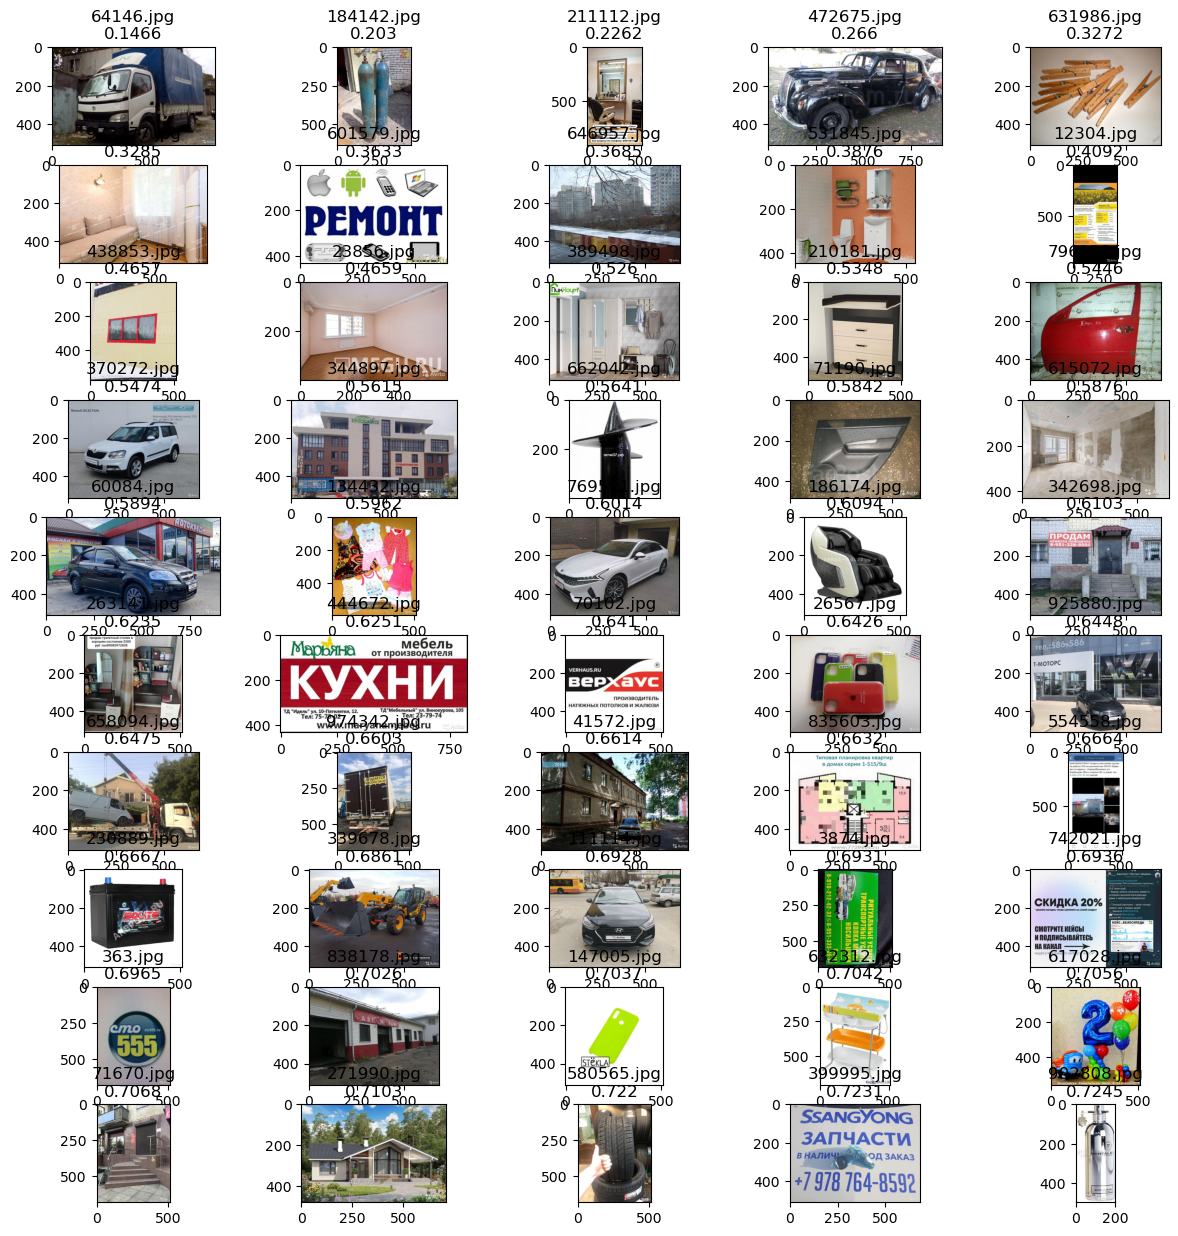

In [49]:
plot_preds(
    logits=np.array(probs_train).flatten(),
    labels=X_train.is_contact.astype(int).values.flatten(),
    pathes=X_train.img_path.values.flatten(),
    mode='fn',
    n_samples=50,
    figsize=(15, 15)
)

### Submission

In [ ]:
test_dataset = Dataset(test, mode='test', transforms=test_transforms)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [ ]:
scores = predict(
    model,
    MODELS[RUN_NAME],
    test_dl
)

In [ ]:
sample_submission.loc[:, 'prediction'] = np.array(scores)
sample_submission.to_csv(RUN_NAME + '_predict.csv', index=False)

In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(fr'{RUN_NAME}_predict.csv')

In [ ]:
import wandb
wandb.finish()